In [2]:
import scipy.io
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# Data preparation

In [29]:
mat = scipy.io.loadmat('ch_cell.mat')
meta_data = scipy.io.loadmat('resp_cell.mat')

ch = mat['ch_cell'] #### num_tx by num_rx
dist = mat['dist']

cir_profile = meta_data['resp_cell']
x, y = meta_data['X'].flatten(), meta_data['Y'].flatten()
Y = np.array([x, y]).T
Y[:, 0] *= 1e3

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\io\matlab\mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [30]:
ray_len = []
delay_set = []

for chs in cir_profile:
    for ch in chs:
        ray_len.append(len(ch[0,:]))
        delay_set.extend(ch[0, :])

max_reflection = max(ray_len)
mag = - math.floor(math.log(np.mean(delay_set), 10))


C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\transforms.py:1969: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


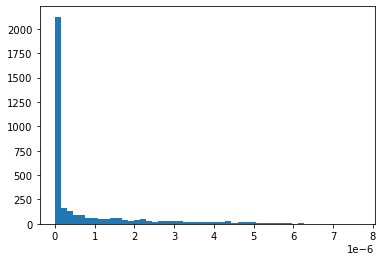

In [31]:
_ = plt.hist(delay_set, bins=50)

Text(0.5, 0, '#-of-raytraces')

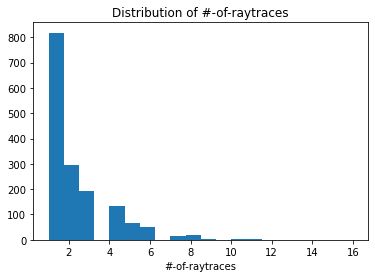

In [6]:
_ = plt.hist(ray_len, bins=20)
plt.title('Distribution of #-of-raytraces')
plt.xlabel('#-of-raytraces')

In [32]:


def z2polar(z):
    '''
    cartisan to polar coordinates
    '''
    return ( abs(z), np.angle(z) )

In [8]:
# prepare X

T, S = cir_profile.shape
x_pre = []
for j in range(T):
    cir_t = [] # channel impulse response for a transmitter
    for i in range(S):
        c_tmp = cir_profile[j, i]
        c_tmp[0, :] = c_tmp[0, :] * 10 ** mag # normalize the delay seconds
        
        m, n = c_tmp.shape
        if m == 2:
            c_tmp[1, :] = abs(c_tmp[1, :])
            
        cir_shaped = np.pad(c_tmp, \
            ((0,2-m), (0, max_reflection-n)), \
                constant_values=0).flatten() # padding 0 to shape of (2, max_len)
        cir_t.append(np.array(cir_shaped, dtype='float'))

    x_pre.append(np.array(cir_t).flatten())

X = np.array(x_pre)  

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


2

In [246]:
X = cir_profile
mode = 'cov'
T, S = X.shape
x_pre = []
max_len = max_reflection * (max_reflection + 1) // 2

for j in range(T):
    cir_t = [] # channel impulse response for a tx to all rx
    for i in range(S):
        c_tmp = X[j, i] # cir response for t_j and r_i
        c_tmp[0, :] = c_tmp[0, :] * 10 ** mag # normalize the delay seconds            
        m, n = c_tmp.shape # m - 2, n - num of traces
        if m == 2:
            if mode == 'cov':


                if n == 1:
                    cir_cov = np.cov(c_tmp.T)

                    cov_real = cir_cov.real
                    cov_imag = cir_cov.imag 
                    real_flatten = np.array([cov_real])
                    imag_flatten = np.array([cov_imag])
                    pad_zero = np.zeros(max_len - n)

                    tmp = np.concatenate([real_flatten, pad_zero, imag_flatten, pad_zero])
                    cir_t.append(tmp)

                else:
                    cir_cov = np.cov(c_tmp.T)
                    cir_cov /= np.trace(cir_cov)
                    cov_real = cir_cov.real
                    cov_imag = cir_cov.imag               

                    real_flatten = cov_real[np.triu_indices(n)]
                    imag_flatten = cov_imag[np.triu_indices(n)]

                    real_pad = np.pad(real_flatten, (0, max_len - len(real_flatten)), constant_values=0)
                    imag_pad = np.pad(imag_flatten, (0, max_len - len(imag_flatten)), constant_values=0)

                    print(max(real_pad), max(imag_pad))

                    cir_t.append(np.concatenate([real_pad, imag_pad]))
            elif mode == 'abs':
                c_tmp[1, :] = abs(c_tmp[1, :])
                cir_shaped = np.pad(c_tmp, \
                    ((0,2-m), (0, max_reflection-n)), \
                        constant_values=0).flatten() # padding 0 to shape of (2, max_len)
                cir_t.append(np.array(cir_shaped, dtype='float'))

        else:
            if mode == 'cov':
                cir_t.append(np.zeros(max_len * 2))

            elif mode == 'abs':
                cir_shaped = np.pad(c_tmp, \
                    ((0,2-m), (0, max_reflection-n)), \
                        constant_values=0).flatten() # padding 0 to shape of (2, max_len)
                cir_t.append(np.array(cir_shaped, dtype='float'))

    x_pre.append(np.concatenate(np.array(cir_t), axis=0))


C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


nan nan
1.0 0.0
1.0 1.1466283493389942e-152
1.0 4.105078213502799e-151
0.5756814832692636 4.613700475981167e-154
0.6839396744159721 2.671052291640845e-153
1.0 0.0
1.0 3.910071401408718e-154
0.9993066849010527 1.7446368363749715e-154
1.0 1.3377782131432407e-109
0.9999628887694078 0.0
1.0 0.0
1.0 8.476699160735774e-112
0.500002352499541 5.279825370172606e-112
0.9999964797235527 1.799964810418499e-112
1.0 6.565647327855652e-111
0.9310285019267841 1.2755755666639677e-112
0.41666342138707213 3.813597297854067e-114
0.49962096258799776 1.3366995515700994e-112
0.9999999908870063 0.0
1.0 0.0
0.9645873359640444 4.729766329255567e-113
1.0 0.0
1.0 4.512828744840448e-112
0.7419589064640097 4.5450810337867554e-113
1.0 7.476122548647628e-112
1.0 0.0
0.5000405516665829 3.287305808226227e-113
1.0 7.747437804952332e-111
1.0 0.0
0.7237338704694132 6.859636822947868e-112
1.0 0.0
1.0 1.1069746370244927e-111
0.9999999999999999 4.648074031931238e-110
0.40751856834134453 0.0
1.0 0.0
1.0 4.219200060241732e-110

In [162]:
tmp.shape, np.concatenate([real_pad, imag_pad]).shape, real_flatten.shape, n
max_reflection ** 2 // 2, len(real_flatten), c_tmp.shape, cir_cov.shape, 16*16//2, cir_cov[np.triu_indices(n)].shape, cir_cov.shape, i, j, c_tmp.shape
#
l = []
l.append(np.concatenate([real_pad, imag_pad]))
l.append(np.concatenate([real_pad, imag_pad]))
np.array(l).flatten().shape

new_x = []
for i in x_pre:
    if len(i) < 1000:
        new_x.append(i.flatten())
    else:
        new_x.append(i)

In [250]:
X = np.array(x_pre)

In [232]:
def input_formatting(X, max_reflection, mode='cov'):
    T, S = X.shape
    x_pre = []
    for j in range(T):
        cir_t = [] # channel impulse response for a transmitter
        for i in range(S):
            c_tmp = X[j, i] # cir response for t_j and r_i
            c_tmp[0, :] = c_tmp[0, :] * 10 ** mag # normalize the delay seconds            
            m, n = c_tmp.shape
            if m == 2:
                if mode == 'cov':
                    cir_cov = np.cov(c_tmp)
                    cov_real = cir_cov.real
                    cov_imag = cir_cov.imag

                    real_flatten = cov_real[np.triu_indices(n)]
                    imag_flatten = cov_imag[np.triu_indices(n)]

                    real_pad = np.pad(real_flatten, (0, max_reflection ** 2 / 2 - n), constant_values=0)
                    imag_pad = np.pad(imag_flatten, (0, max_reflection **  2 / 2 -n), constant_values=0)

                    print(max(real_pad), max(imag_pad))

                    cir_t.append(np.concatenate([real_pad, imag_pad]))
                elif mode == 'abs':
                    c_tmp[1, :] = abs(c_tmp[1, :])
                    cir_shaped = np.pad(c_tmp, \
                        ((0,2-m), (0, max_reflection-n)), \
                            constant_values=0).flatten() # padding 0 to shape of (2, max_len)
                    cir_t.append(np.array(cir_shaped, dtype='float'))

            else:
                if mode == 'cov':
                    cir_t.append(np.zeros(max_reflection ** 2))

                elif mode == 'abs':
                    cir_shaped = np.pad(c_tmp, \
                        ((0,2-m), (0, max_reflection-n)), \
                            constant_values=0).flatten() # padding 0 to shape of (2, max_len)
                    cir_t.append(np.array(cir_shaped, dtype='float'))

        x_pre.append(np.array(cir_t).flatten())

    return np.array(x_pre)  

In [52]:
input_formatting(cir_profile, max_reflection)

IndexError: index 2 is out of bounds for axis 0 with size 2

# Learning

In [251]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler

In [252]:
np.max(X)

nan

In [264]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, train_size=.75)
xgb_reg = xgb.XGBRegressor(n_estimators=100, max_depth=1000, eta=0.1, subsample=0.7, colsample_bytree=0.8)
# xgb_reg = xgb.XGBRegressor()
model = MultiOutputRegressor(xgb_reg)

In [265]:
_ = model.fit(x_train, y_train)

In [266]:
y_pred = model.predict(x_test)
mean_squared_error(y_test, y_pred)

21.576516960649347

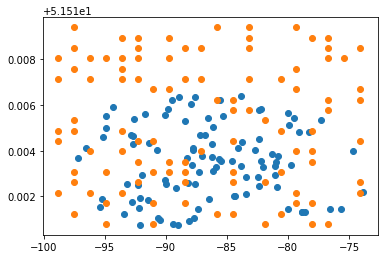

In [267]:
plt.scatter(y_pred[:, 0], y_pred[:,1])
plt.scatter(y_test[:, 0], y_test[:, 1])

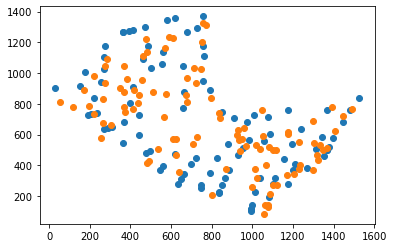

In [27]:
plt.scatter(y_test[:, 0], y_test[:, 2])
plt.scatter(y_pred[:, 0], y_pred[:, 2])

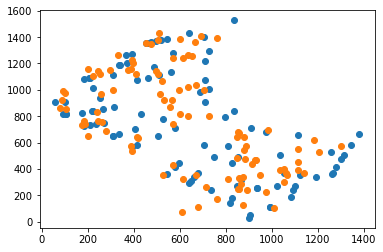

In [28]:
plt.scatter(y_test[:, 3], y_test[:, 1])
plt.scatter(y_pred[:, 3], y_pred[:, 1])